# Feature Extraction & Data cleansing

In [51]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from sklearn.preprocessing import minmax_scale

from pydub import AudioSegment
import fleep
import librosa
import librosa.display

from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures

## Data Cleansing
#### Segmentation

In [2]:
def split_audio(audio, part_length):
    audio_length = len(audio)
    part_count = audio_length // part_length
    extra = audio_length - part_count * part_length
    start = extra // 2
    for i in range(part_count):
        yield audio[start: start + part_length], i
        start += part_length

#### Conversion to wav

In [3]:
def convert_files(files_path, final_path, part_length):
    for file_name in os.listdir(files_path):
        file_path = files_path + os.sep + file_name
        with open(file_path, 'rb') as file:
            info = fleep.get(file.read(128))
        if len(info.extension) == 0:
            continue
        audio = AudioSegment.from_file(file_path, format=info.extension[0])
        for part, i in split_audio(audio, part_length):
            part_name = '.'.join(file_name.split('.')[:-1]) + '_' + str(i) + '.wav'
            part_path = final_path + os.sep + part_name
            part.export(part_path, format='wav')

In [4]:
def prepare_files(data_path, final_path, categories, part_length):
    os.makedirs(final_path, exist_ok=True)
    for i in range(len(categories)):
        category_path = data_path + os.sep + 'D_' + str(i)
        final_category_path = final_path + os.sep + categories[i]
        os.makedirs(final_category_path, exist_ok=True)
        for category_dir in os.listdir(category_path):
            instrument_path = category_path + os.sep + category_dir
            convert_files(instrument_path, final_category_path, part_length)

In [ ]:
categories = ['D_0', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6']
prepare_files('./Data', './ConvertedData', categories, 30000)

#### Visualization

In [39]:
for dastgah in range(7):
    directory_path = "./ConvertedData"
    music_dir = directory_path + os.sep + "D_" + str(dastgah)
    music_name = ''
    for music in os.listdir(music_dir):
        music_name = music
        break

    shutil.copy(music_dir + os.sep + music_name, "./samples/D_" + str(dastgah) + ".wav")

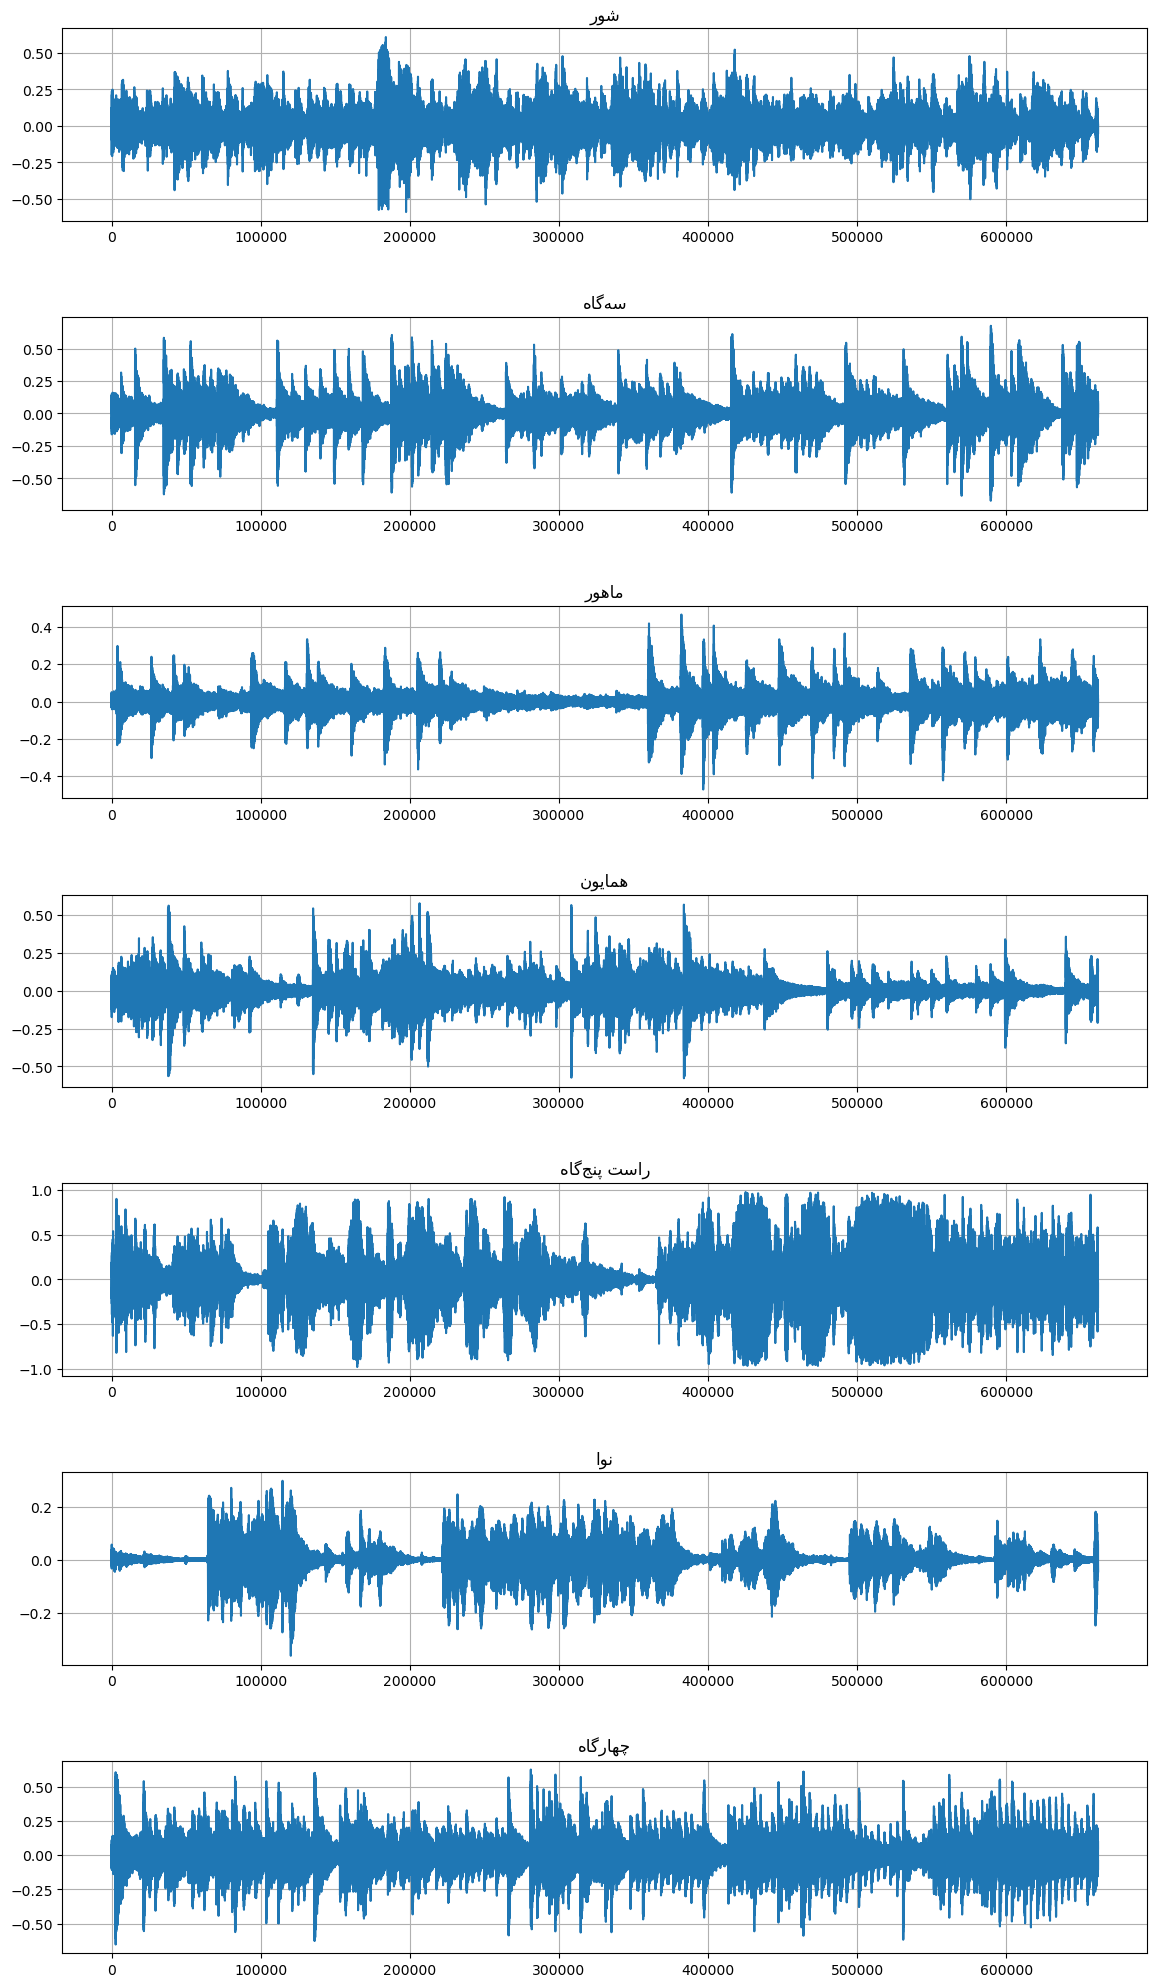

In [55]:
dastgah = {
    0: "شور",
    1: "سه‌گاه",
    2: "ماهور",
    3: "همایون",
    4: "راست پنج‌گاه",
    5: "نوا",
    6: "چهارگاه"
}

labels = dastgah.values()
persian_labels = [get_display(reshape(label)) for label in labels]

plt.figure(figsize=(14, 25))

for i in dastgah.keys():
    y, sr = librosa.load("./samples/D_" + str(i) + ".wav")

    plt.subplot(7, 1, i + 1)
    plt.subplots_adjust(hspace=0.5)
    plt.plot(y)
    plt.grid()
    plt.title(persian_labels[i])

plt.show()

## Feature Extraction
#### MFCC

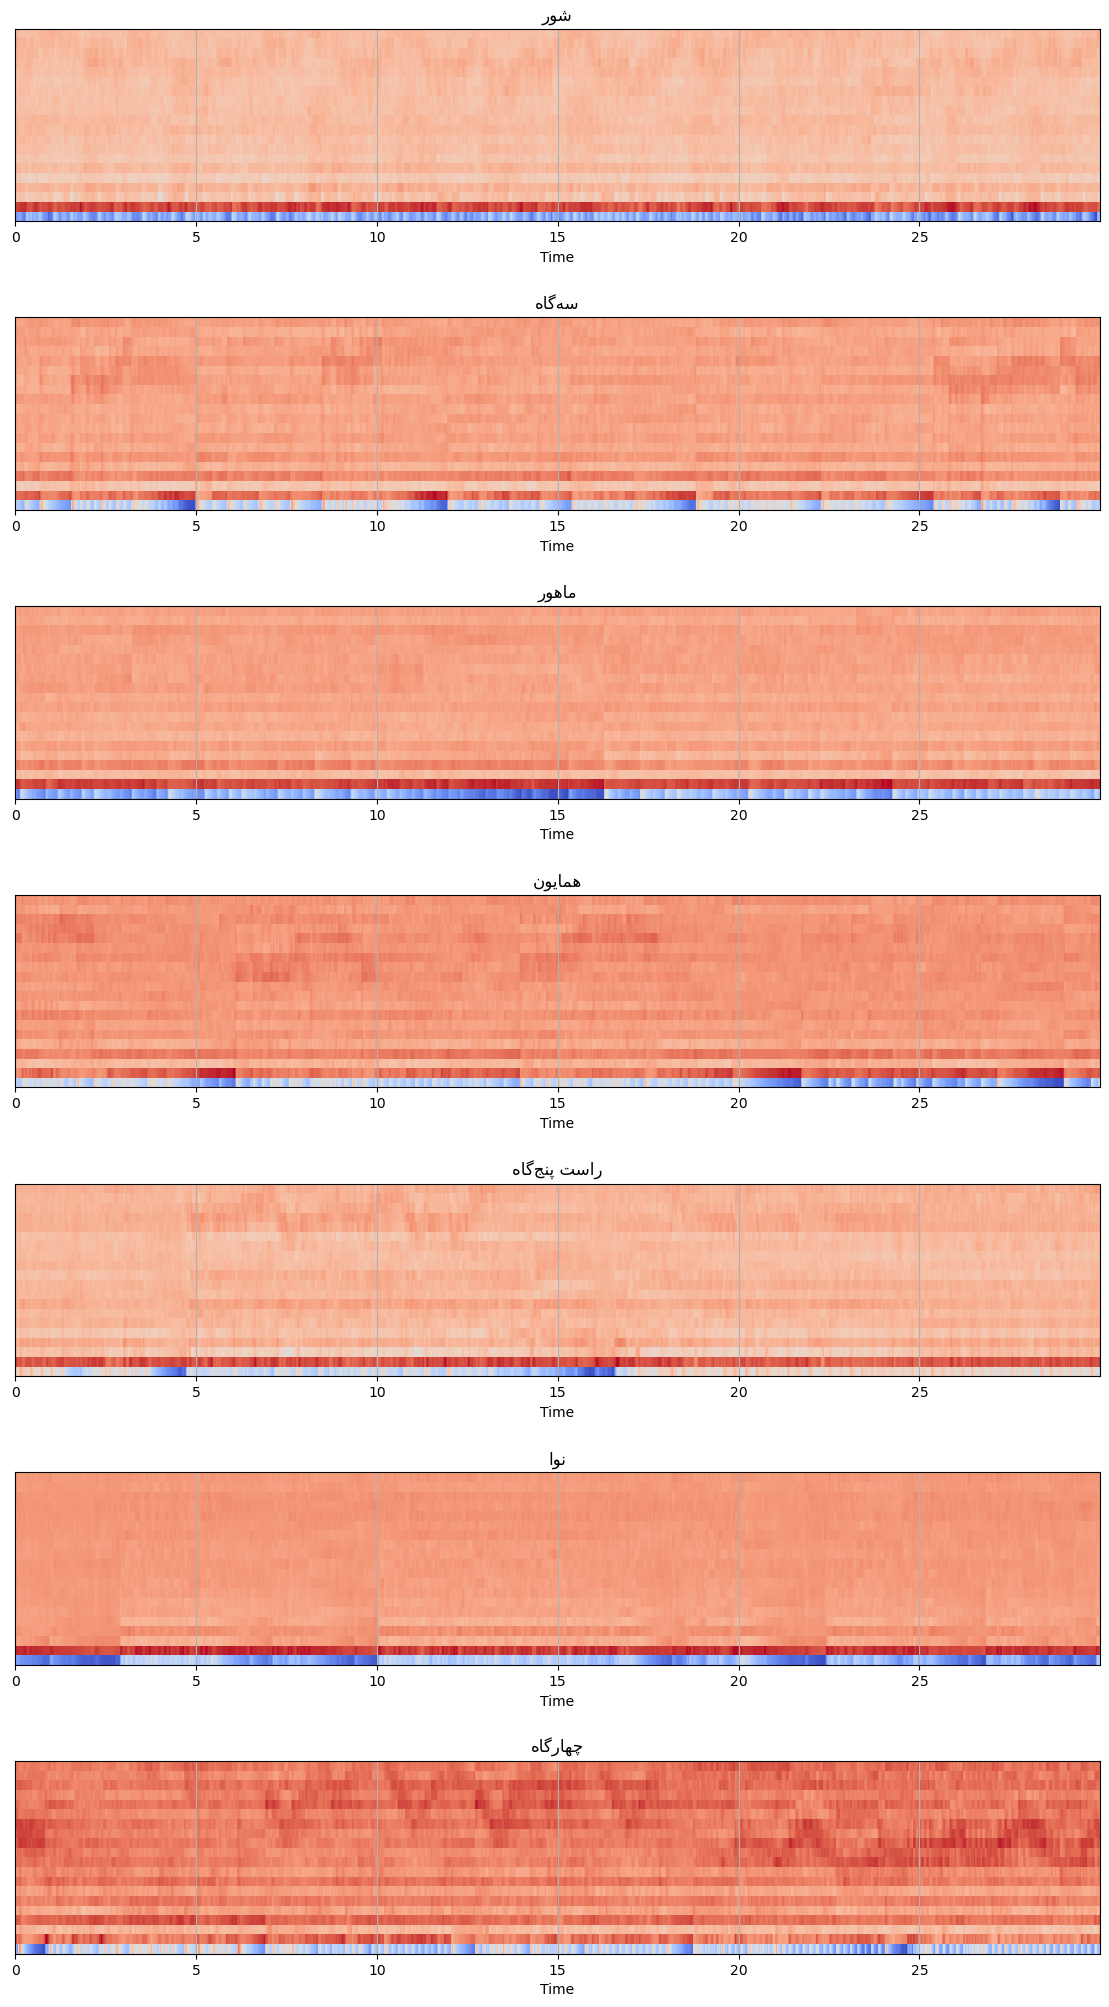

In [54]:
plt.figure(figsize=(14, 25))

for i in dastgah.keys():
    y, sr = librosa.load("./samples/D_" + str(i) + ".wav")

    plt.subplot(7, 1, i + 1)
    plt.subplots_adjust(hspace=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')
    plt.grid()
    plt.title(persian_labels[i])

plt.show()

#### Chromagram

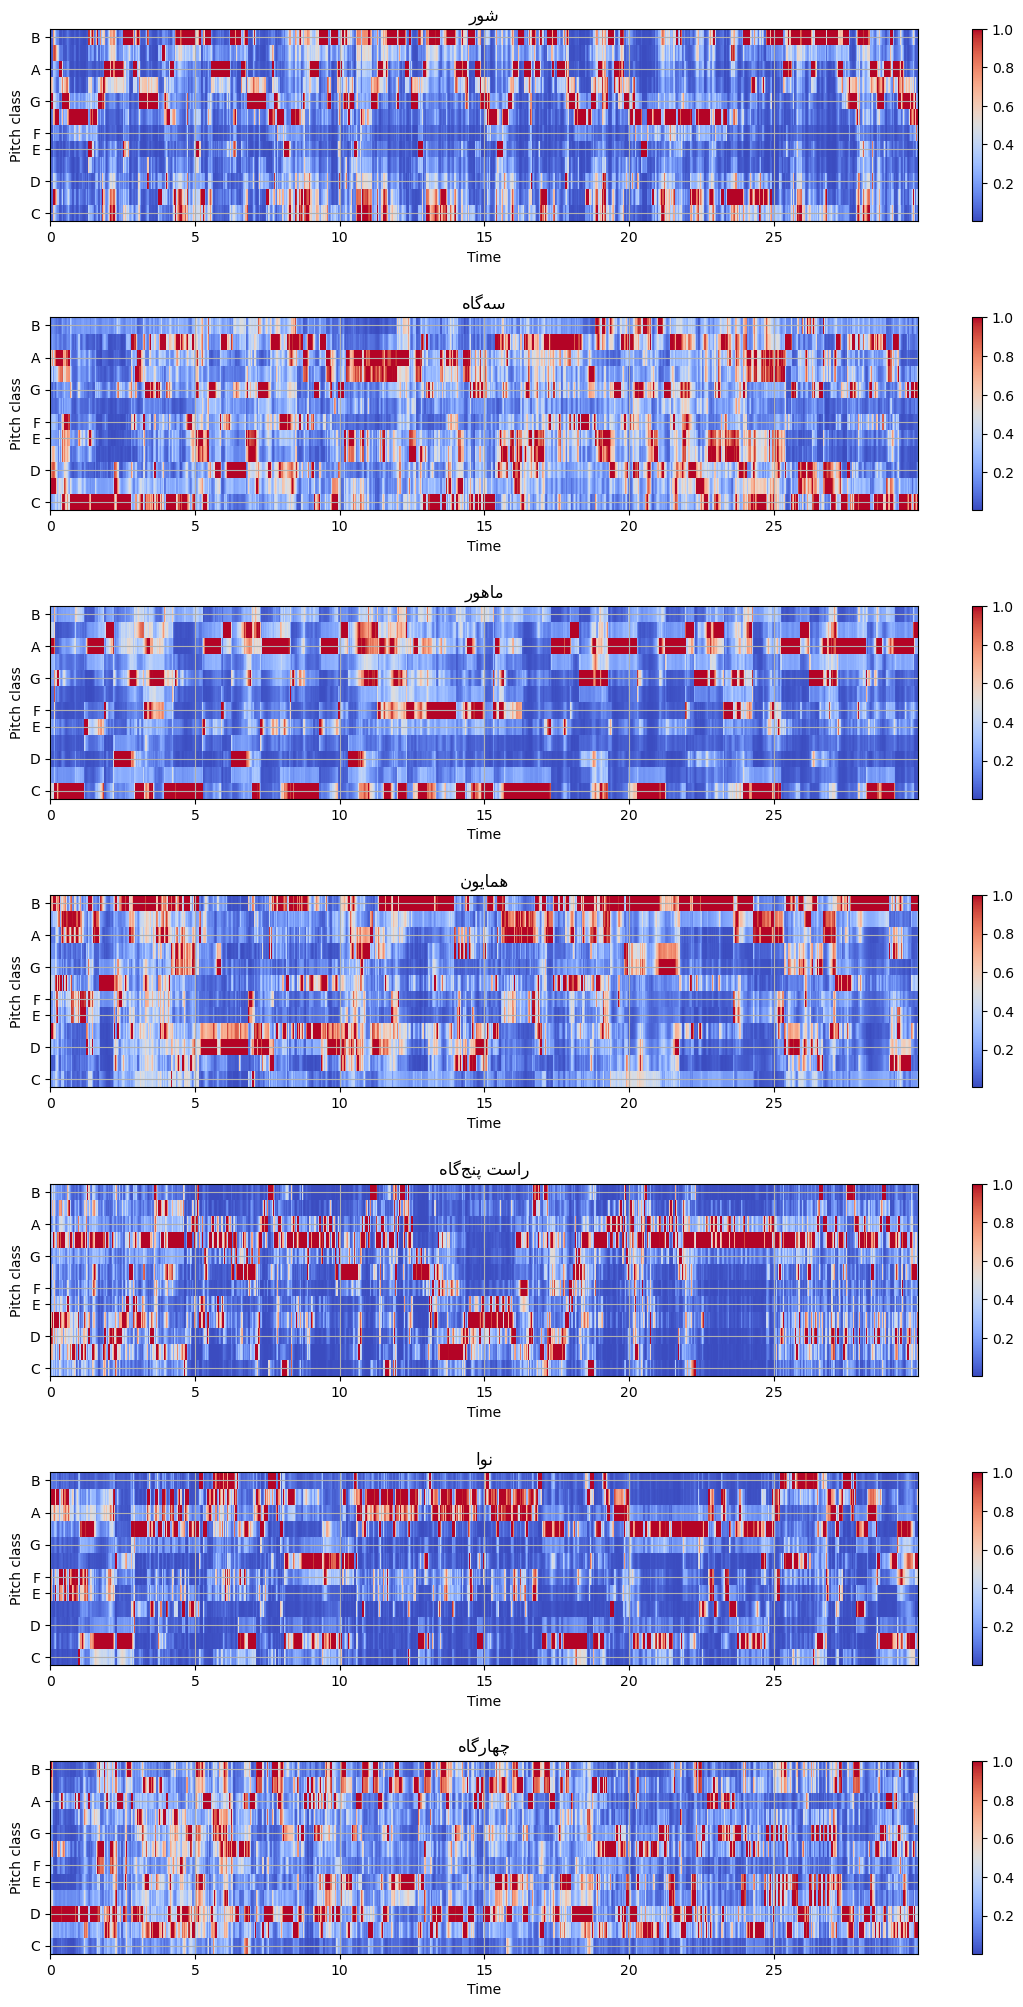

In [45]:
plt.figure(figsize=(14, 25))

for i in dastgah.keys():
    y, sr = librosa.load("./samples/D_" + str(i) + ".wav")

    plt.subplot(7, 1, i + 1)
    plt.subplots_adjust(hspace=0.5)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    f = librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
    plt.colorbar(f)
    plt.grid()
    plt.title(persian_labels[i])

plt.show()

#### Spectral Roll off

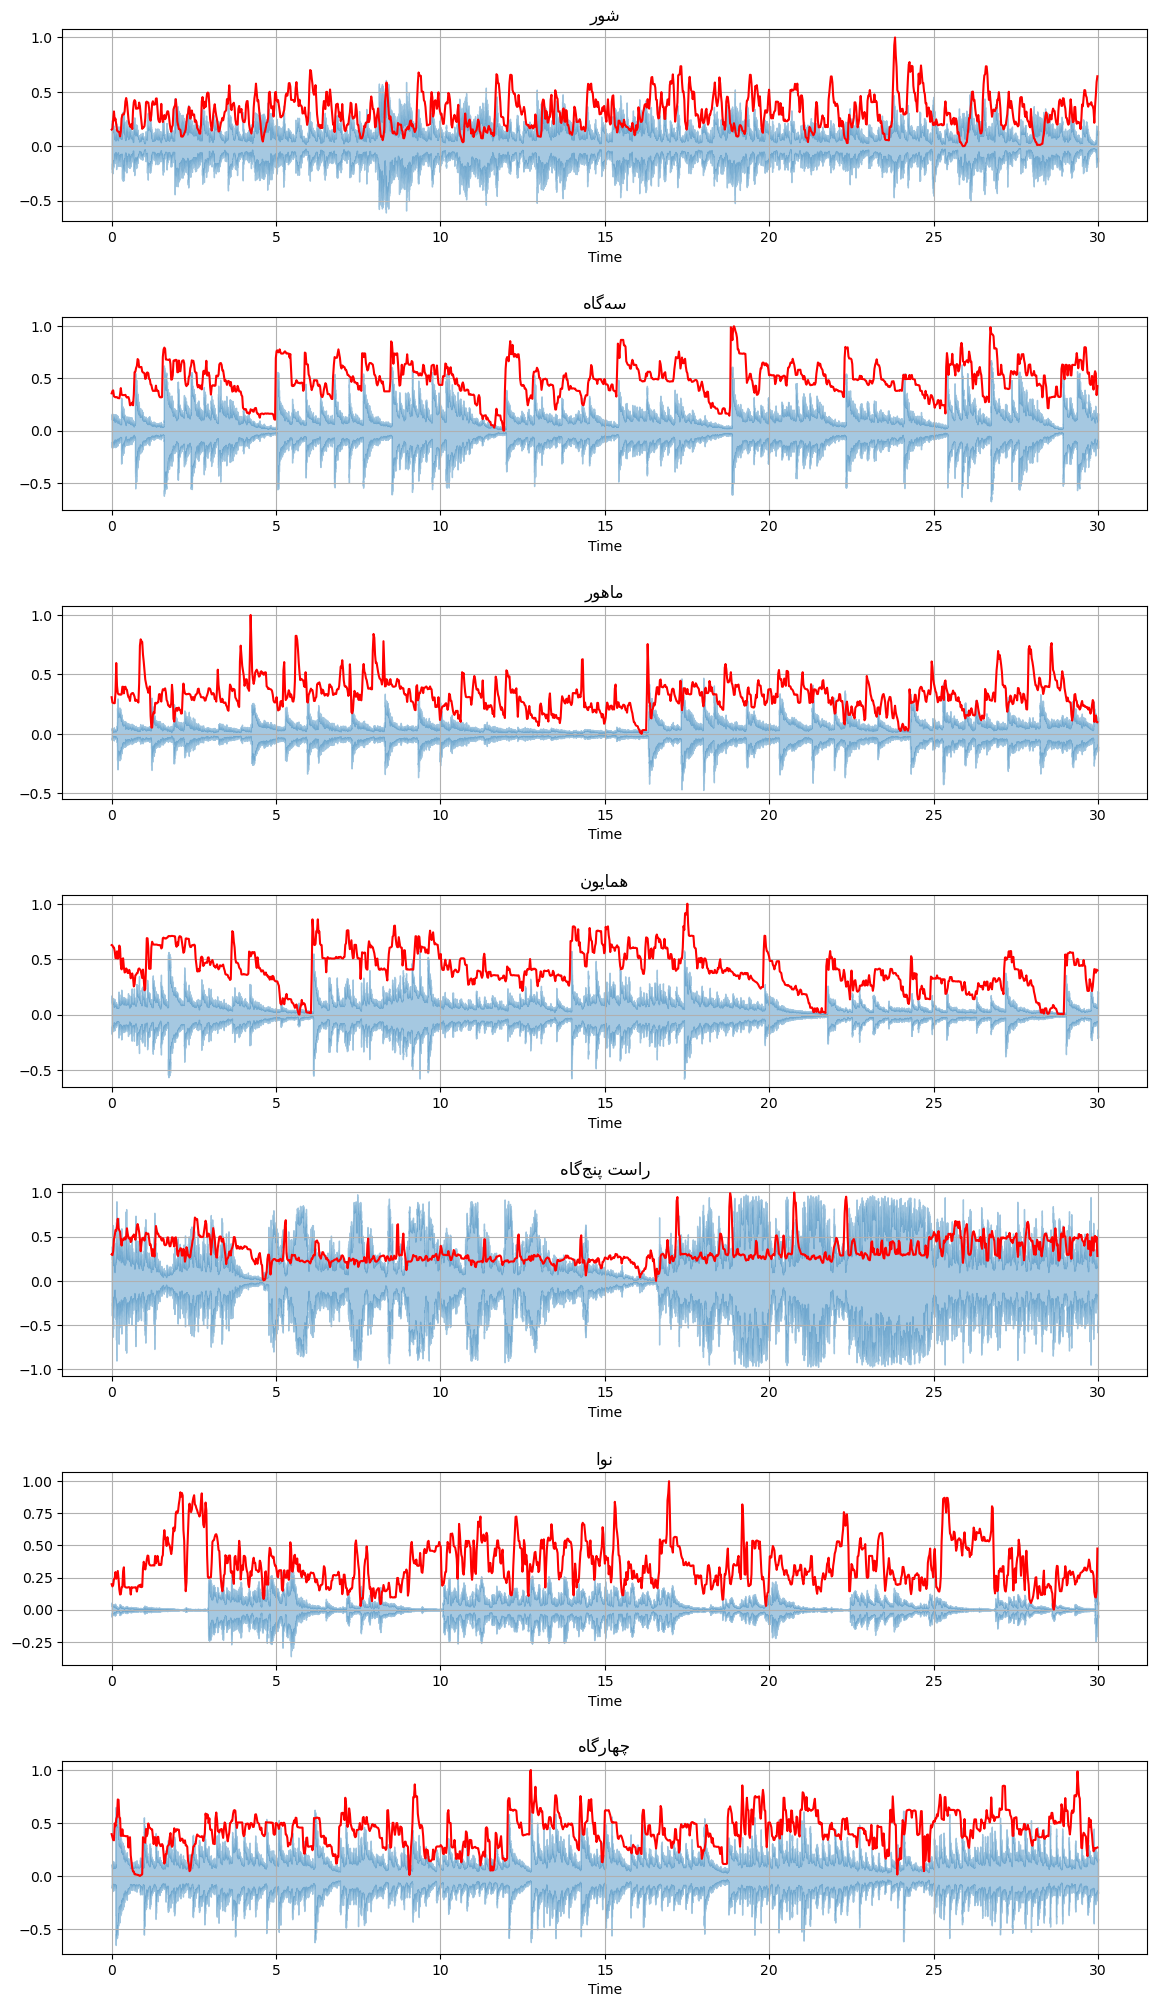

In [57]:
plt.figure(figsize=(14, 25))

for i in dastgah.keys():
    y, sr = librosa.load("./samples/D_" + str(i) + ".wav")

    plt.subplot(7, 1, i + 1)
    plt.subplots_adjust(hspace=0.5)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(y, sr=sr, alpha=0.4)
    plt.plot(t, minmax_scale(spectral_rolloff), color='r')
    plt.grid()
    plt.title(persian_labels[i])

plt.show()

#### Spectral Centroid

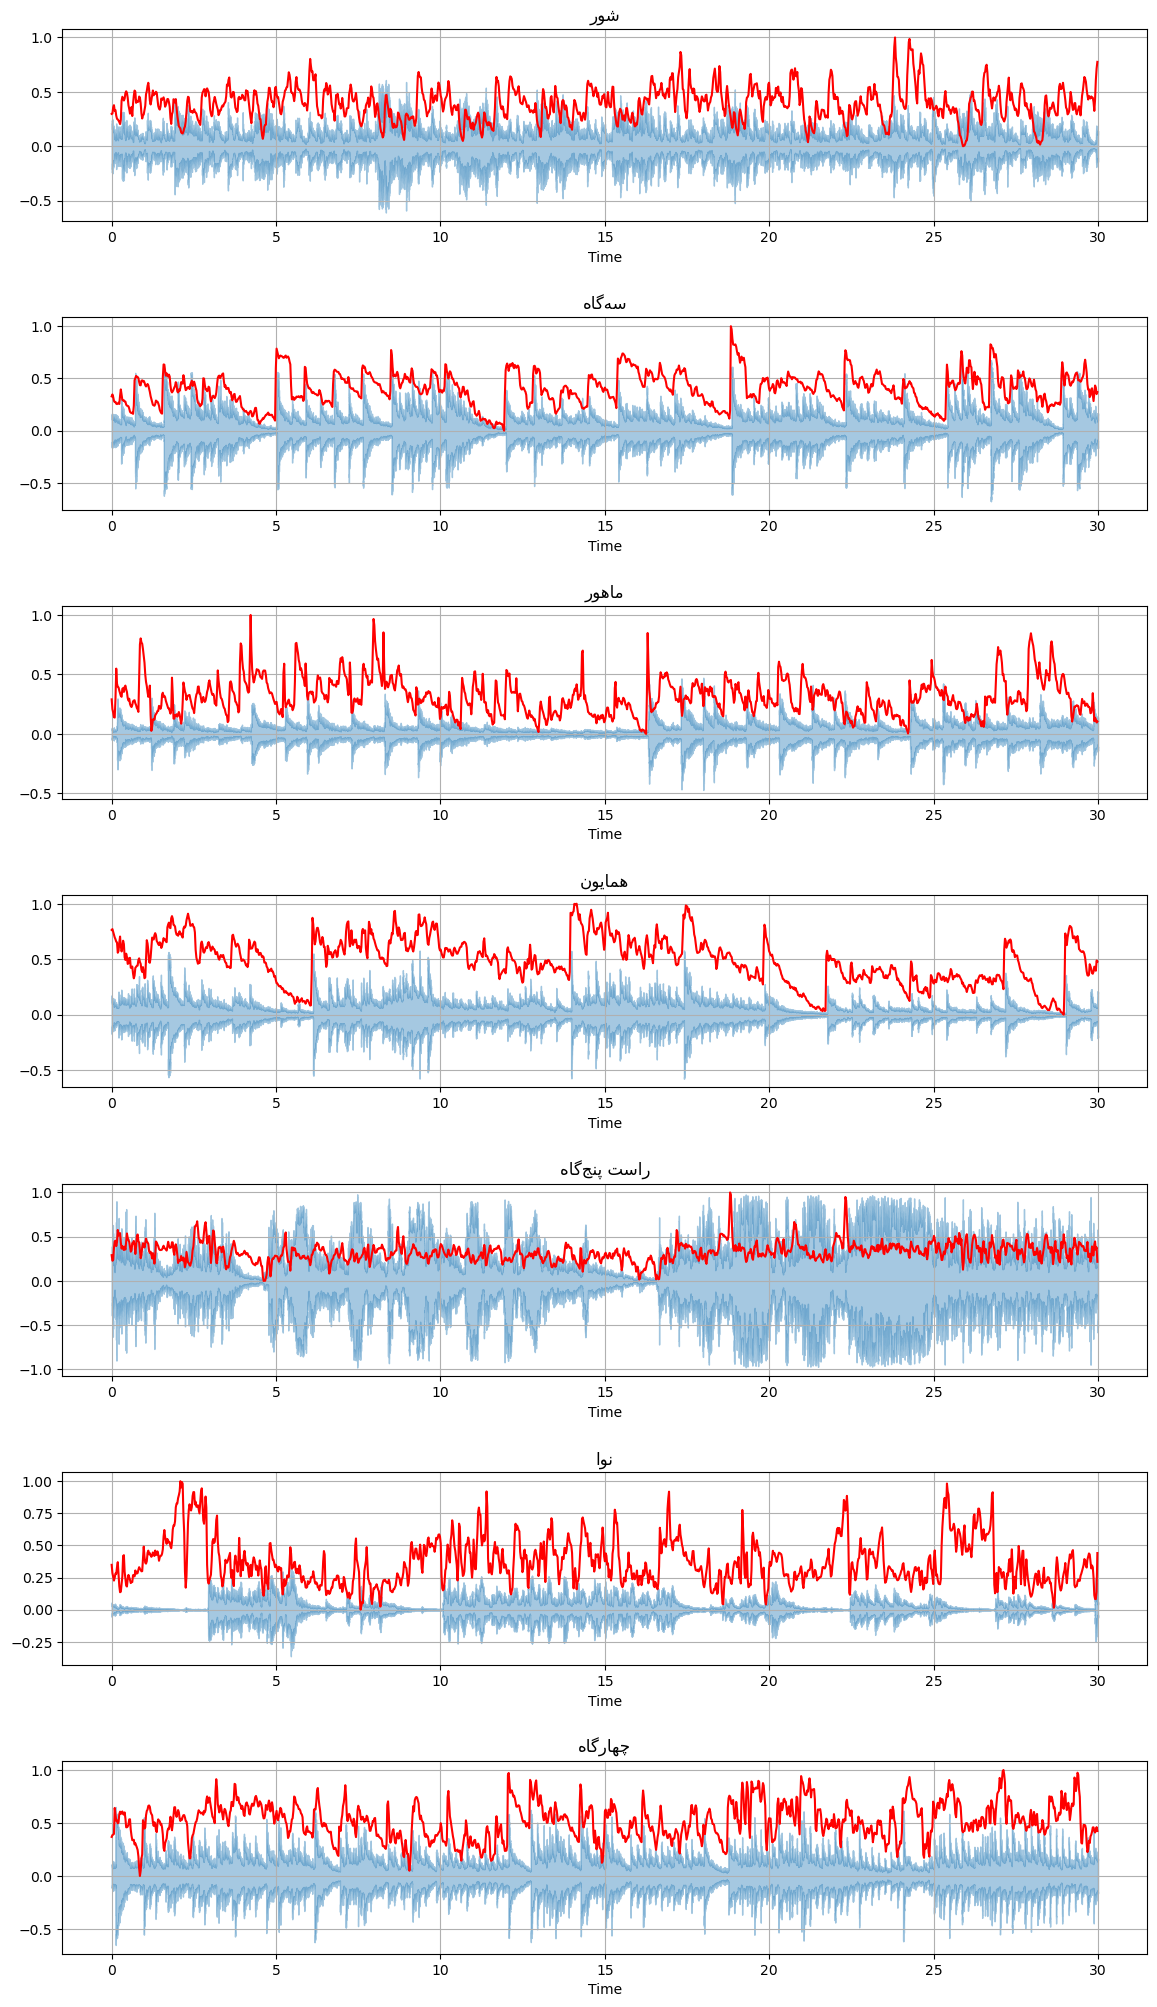

In [58]:
plt.figure(figsize=(14, 25))

for i in dastgah.keys():
    y, sr = librosa.load("./samples/D_" + str(i) + ".wav")

    plt.subplot(7, 1, i + 1)
    plt.subplots_adjust(hspace=0.5)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    frames = range(len(spectral_centroid))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(y, sr=sr, alpha=0.4)
    plt.plot(t, minmax_scale(spectral_centroid), color='r')
    plt.grid()
    plt.title(persian_labels[i])

plt.show()

In [ ]:
def extract_features_librosa(data, sample_rate):
    features = []
    # MFCC
    mfcc = librosa.feature.mfcc(y=data)
    features += mfcc.mean(axis=1).tolist()
    features += mfcc.var(axis=1).tolist()

    # Zero-Crossing rate
    zcr = librosa.feature.zero_crossing_rate(y=data)
    features.append(np.mean(zcr))

    # Spectral roll off
    spectral_rolloffs = librosa.feature.spectral_rolloff(y=data, sr=sample_rate)
    features.append(np.mean(spectral_rolloffs))
    features.append(np.var(spectral_rolloffs))

    # Chroma
    chroma = librosa.feature.chroma_stft(y=data, sr=sample_rate)
    features += chroma.mean(axis=1).tolist()
    features += chroma.var(axis=1).tolist()

    # Spectral Centroid
    spectral_centroids = librosa.feature.spectral_centroid(y=data, sr=sample_rate)
    features.append(spectral_centroids.mean())
    features.append(spectral_centroids.var())

    return features

In [10]:
def prepare_csv_librosa(data_path, final_path, categories):
    data_mat = []
    os.makedirs(final_path, exist_ok=True)
    for category in categories:
        category_path = data_path + os.sep + category
        for file_name in os.listdir(category_path):
            file_path = category_path + os.sep + file_name
            data, sample_rate = librosa.load(file_path)
            new_row = [category]
            new_row += extract_features_librosa(data, sample_rate)
            data_mat.append(new_row)
            
        csv_path = final_path + os.sep + category +'.csv'
        df = pd.DataFrame(data_mat)
        df.to_csv(csv_path)
        data_mat = []

In [ ]:
prepare_csv_librosa('./ConvertedData', './CSVFiles', ['D_0', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6'])

In [7]:
csv_dir = './CSVFiles'
df = pd.DataFrame()
for csv_name in os.listdir(csv_dir):
    csv_path = csv_dir + os.sep + csv_name
    df = pd.concat([df, pd.read_csv(csv_path, index_col='Unnamed: 0')])
df.to_csv('data.csv', index=False)

In [17]:
def extract_features_paa(audio_path):
    [Fs, S] = audioBasicIO.read_audio_file(audio_path)
    S = audioBasicIO.stereo_to_mono(S)
    return ShortTermFeatures.feature_extraction(S, Fs, 0.050*Fs, 0.025*Fs)

In [26]:
def prepare_csv_paa(data_path, categories):
    data_dict = {'category': []}
    for category in categories:
        category_path = data_path + os.sep + category
        for file_name in os.listdir(category_path):
            file_path = category_path + os.sep + file_name
            data_dict['category'].append(category)
            features, feature_names = extract_features_paa(file_path)
            if len(data_dict) == 1:
                for fn in feature_names:
                    data_dict[fn] = []
            for i, fn in enumerate(feature_names):
                data_dict[fn].append(np.mean(features[i]))

    df = pd.DataFrame(data_dict)
    df.to_csv('data_paa.csv', index=False)

In [28]:
prepare_csv_paa('./ConvertedData', ['D_0', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6'])